In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import json
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
os.makedirs('../data/embeddings', exist_ok=True)
os.makedirs('../models/yamnet', exist_ok=True)

In [11]:
print("LOADING YAMNET MODEL")

# YAMNet from TensorFlow Hub
YAMNET_MODEL_HANDLE = 'https://tfhub.dev/google/yamnet/1'

print(f"\nDownloading YAMNet from: {YAMNET_MODEL_HANDLE}")
print("This may take a few minutes on first run...")

yamnet_model = hub.load(YAMNET_MODEL_HANDLE)

print("\n✓ YAMNet model loaded successfully!")
print(f"Model input shape: Variable length audio at 16kHz")
print(f"Model output: 1024-dimensional embeddings")


LOADING YAMNET MODEL

This may take a few minutes on first run...

✓ YAMNet model loaded successfully!
Model input shape: Variable length audio at 16kHz
Model output: 1024-dimensional embeddings


In [12]:
def load_audio_for_yamnet(filepath):
    """Load audio file in YAMNet format"""
    # YAMNet expects float32 audio at 16kHz in range [-1, 1]
    wav_data, sr = librosa.load(filepath, sr=16000, mono=True)
    # Ensure float32
    wav_data = wav_data.astype(np.float32)
    return wav_data

def extract_yamnet_embeddings(audio_data):
    """
    Extract embeddings from audio using YAMNet
    Returns: embeddings (N, 1024) where N is number of frames
    """
    # YAMNet produces one embedding every 0.48 seconds
    scores, embeddings, spectrogram = yamnet_model(audio_data)
    return embeddings.numpy(), scores.numpy()

def process_audio_file_embeddings(filepath):
    """Process single audio file and extract embeddings"""
    audio_data = load_audio_for_yamnet(filepath)
    embeddings, scores = extract_yamnet_embeddings(audio_data)
    
    # Average embeddings across time for fixed-size representation
    avg_embedding = np.mean(embeddings, axis=0)
    return avg_embedding, embeddings, scores

def extract_dataset_embeddings(data_dir='../data/processed'):
    """Extract embeddings for entire dataset"""
    embeddings_data = {
        'embeddings': [],
        'labels': [],
        'filenames': [],
        'class_names': []
    }
    
    # Load dataset info
    with open(os.path.join(data_dir, 'dataset_info.json'), 'r') as f:
        dataset_info = json.load(f)
    
    class_names = dataset_info['classes']
    embeddings_data['class_names'] = class_names
    
    print("\nExtracting embeddings...")
    
    for class_idx, class_name in enumerate(class_names):
        print(f"\nProcessing class: {class_name}")
        class_dir = os.path.join(data_dir, class_name)
        
        audio_files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
        
        for audio_file in tqdm(audio_files, desc=f"Extracting {class_name}"):
            filepath = os.path.join(class_dir, audio_file)
            
            try:
                avg_embedding, _, _ = process_audio_file_embeddings(filepath)
                
                embeddings_data['embeddings'].append(avg_embedding)
                embeddings_data['labels'].append(class_idx)
                embeddings_data['filenames'].append(audio_file)
                
            except Exception as e:
                print(f"Error processing {audio_file}: {e}")
    
    # Convert to numpy arrays
    embeddings_data['embeddings'] = np.array(embeddings_data['embeddings'])
    embeddings_data['labels'] = np.array(embeddings_data['labels'])
    
    return embeddings_data

# Extract embeddings
embeddings_data = extract_dataset_embeddings('../data/processed')

# Save embeddings
print("\nSaving embeddings...")
np.save('../data/embeddings/embeddings.npy', embeddings_data['embeddings'])
np.save('../data/embeddings/labels.npy', embeddings_data['labels'])

with open('../data/embeddings/metadata.json', 'w') as f:
    json.dump({
        'class_names': embeddings_data['class_names'],
        'filenames': embeddings_data['filenames'],
        'num_samples': len(embeddings_data['labels']),
        'embedding_dim': embeddings_data['embeddings'].shape[1]
    }, f, indent=2)

print("✓ Embeddings saved!")


Extracting embeddings...

Processing class: car_honk


Extracting car_honk: 100%|██████████| 24/24 [00:01<00:00, 19.52it/s]



Processing class: cat


Extracting cat: 100%|██████████| 24/24 [00:01<00:00, 21.83it/s]



Processing class: dog


Extracting dog: 100%|██████████| 25/25 [00:01<00:00, 20.52it/s]



Processing class: police_siren


Extracting police_siren: 100%|██████████| 24/24 [00:01<00:00, 18.98it/s]


Saving embeddings...
✓ Embeddings saved!


In [13]:
print(f"\nTotal samples: {len(embeddings_data['labels'])}")
print(f"Embedding dimension: {embeddings_data['embeddings'].shape[1]}")
print(f"\nSamples per class:")
for idx, class_name in enumerate(embeddings_data['class_names']):
    count = np.sum(embeddings_data['labels'] == idx)
    print(f"  {class_name}: {count}")


Total samples: 97
Embedding dimension: 1024

Samples per class:
  car_honk: 24
  cat: 24
  dog: 25
  police_siren: 24



Computing t-SNE projection (this may take a minute)...


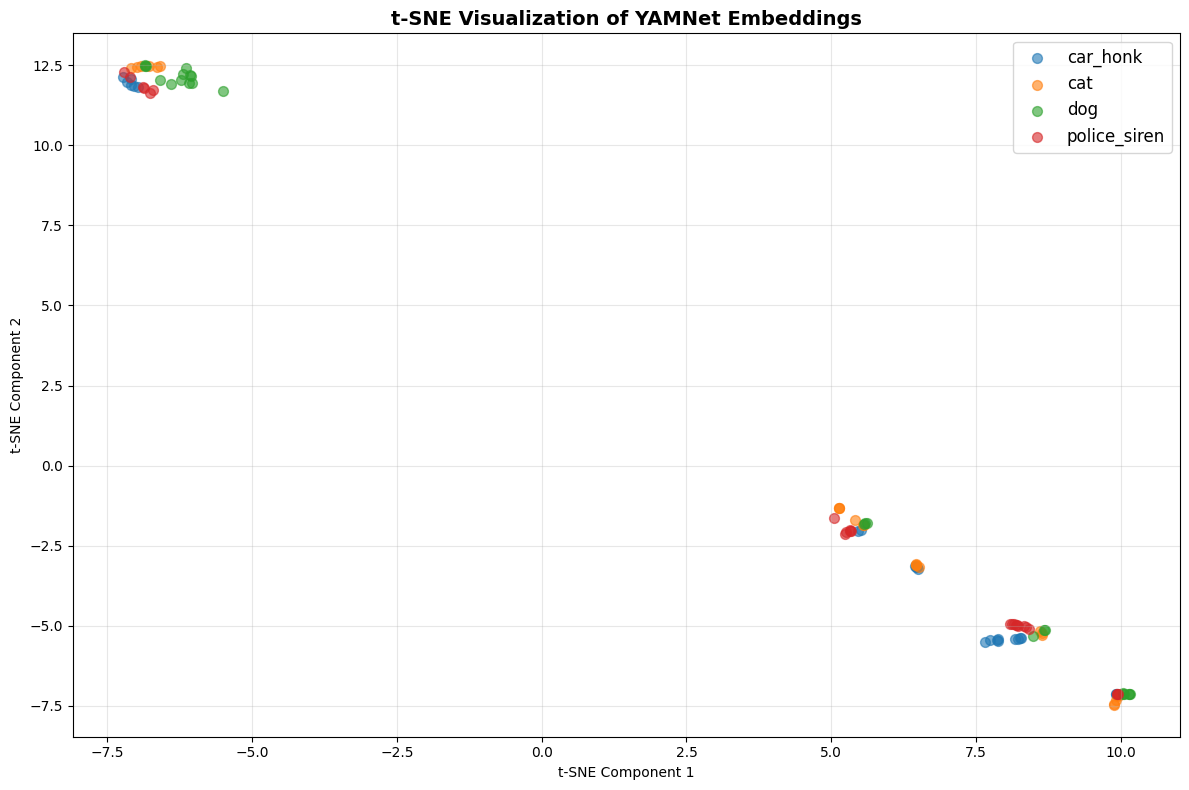

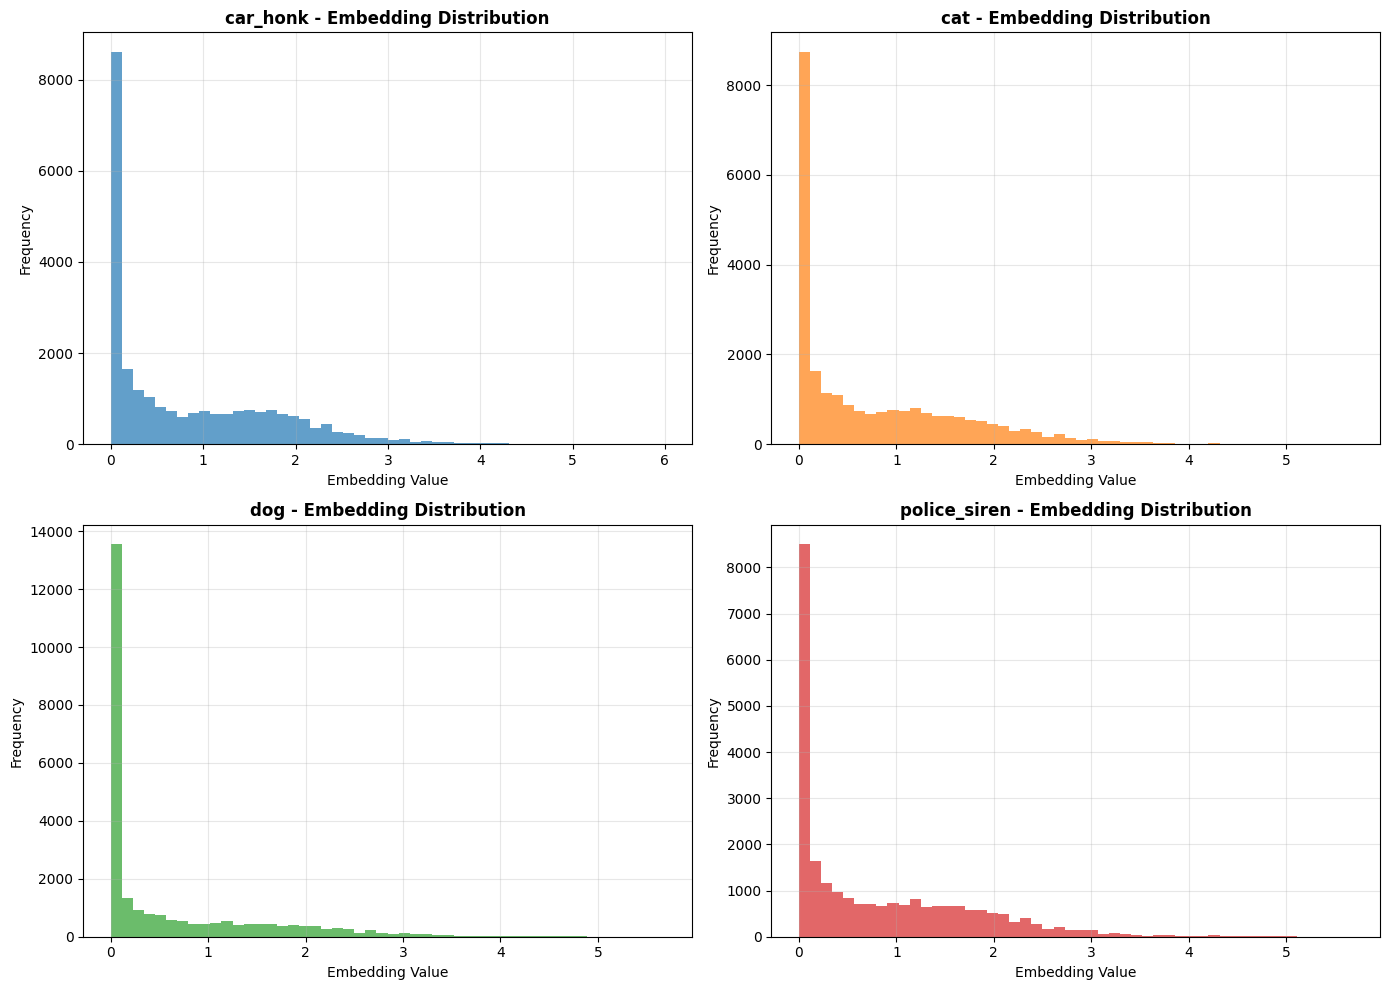


Generating embedding heatmap for sample files...


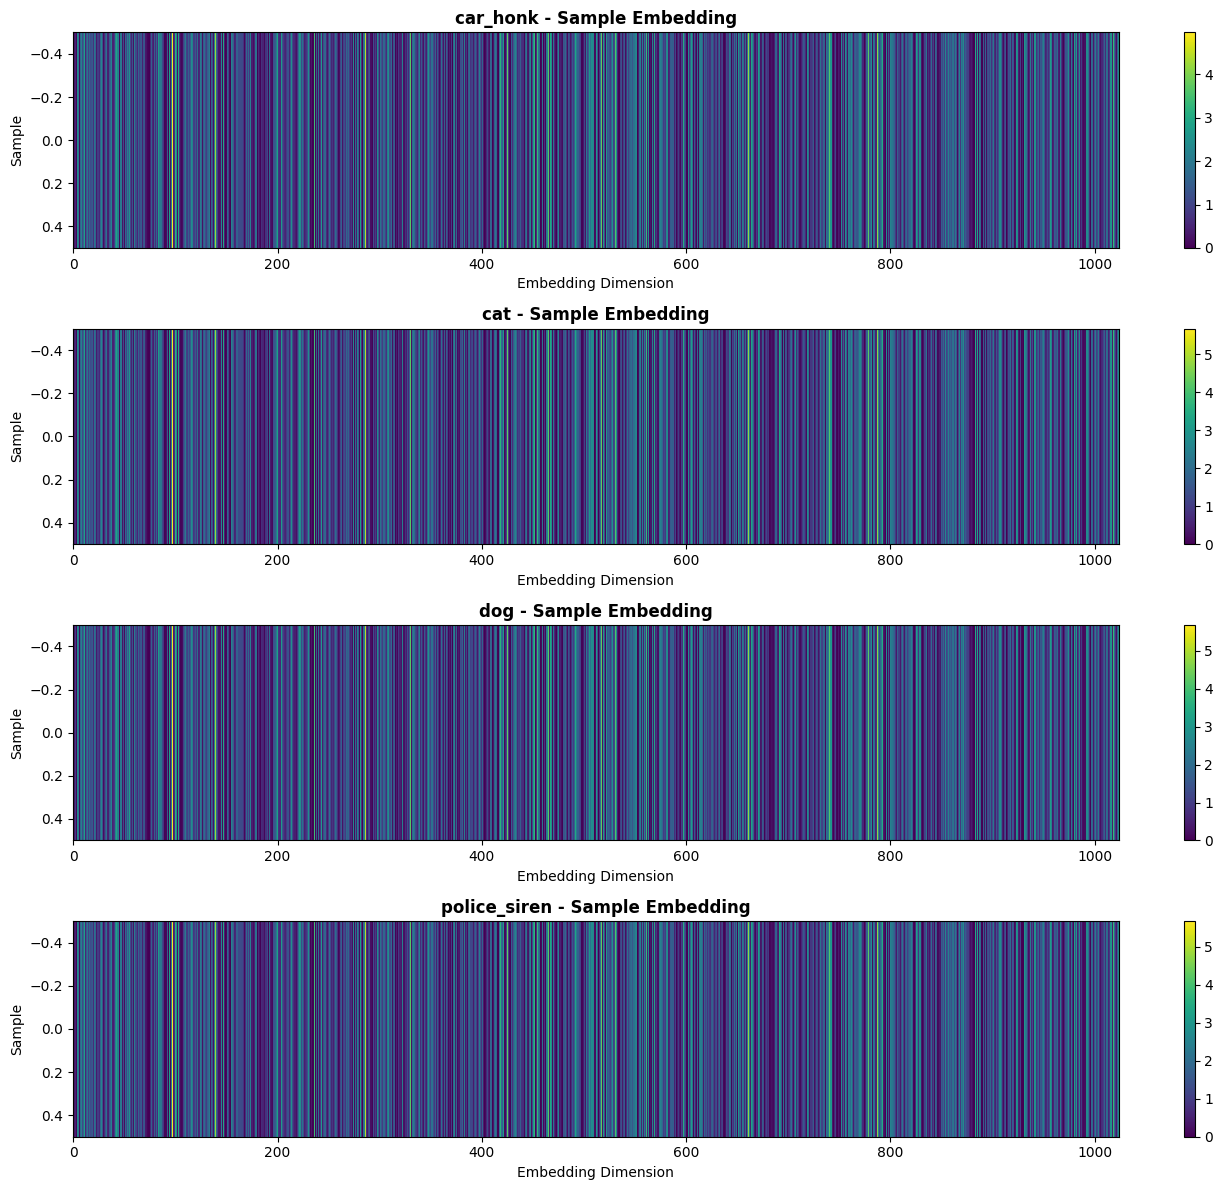


Computing embedding statistics per class...


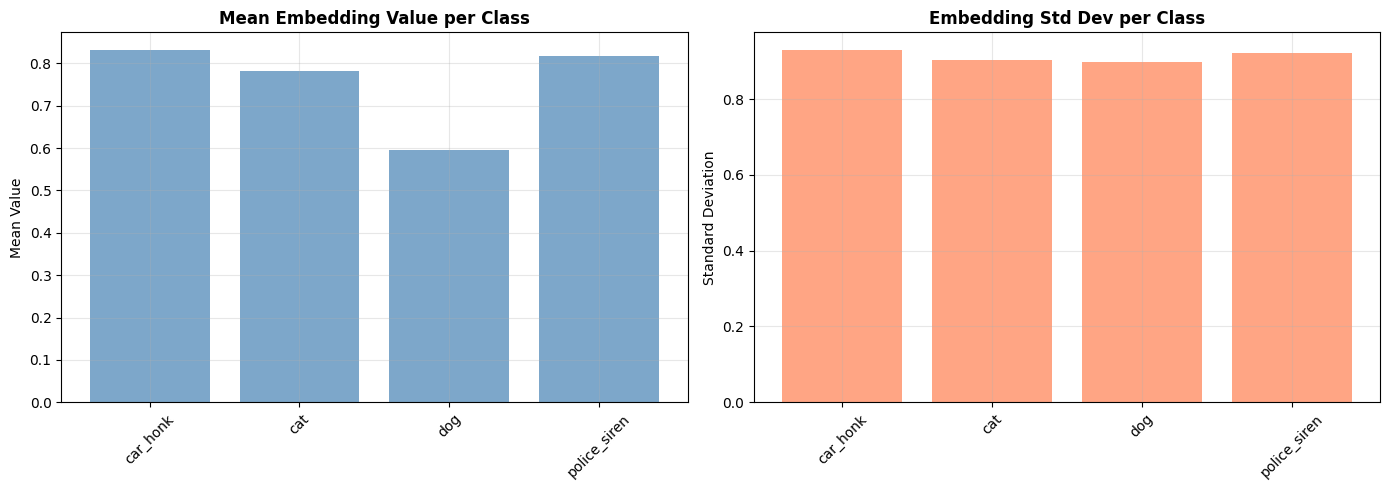


EMBEDDINGS EXTRACTION COMPLETE!

Embeddings saved to: data/embeddings/
- embeddings.npy: (97, 1024)
- labels.npy: (97,)
- metadata.json: Dataset information


In [14]:
# 4.1 t-SNE Visualization
print("\nComputing t-SNE projection (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_data['embeddings'])

plt.figure(figsize=(12, 8))
for idx, class_name in enumerate(embeddings_data['class_names']):
    mask = embeddings_data['labels'] == idx
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                label=class_name, alpha=0.6, s=50)

plt.legend(fontsize=12)
plt.title('t-SNE Visualization of YAMNet Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4.2 Embedding Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, class_name in enumerate(embeddings_data['class_names'][:4]):  # First 4 classes
    if idx >= len(embeddings_data['class_names']):
        break
    ax = axes[idx // 2, idx % 2]
    
    class_embeddings = embeddings_data['embeddings'][embeddings_data['labels'] == idx]
    
    # Plot histogram of embedding values
    ax.hist(class_embeddings.flatten(), bins=50, alpha=0.7, color=f'C{idx}')
    ax.set_title(f'{class_name} - Embedding Distribution', fontweight='bold')
    ax.set_xlabel('Embedding Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4.3 Embedding Heatmap (sample)
print("\nGenerating embedding heatmap for sample files...")
fig, axes = plt.subplots(len(embeddings_data['class_names']), 1, 
                         figsize=(14, 3*len(embeddings_data['class_names'])))

if len(embeddings_data['class_names']) == 1:
    axes = [axes]

for idx, class_name in enumerate(embeddings_data['class_names']):
    # Get first sample from this class
    class_mask = embeddings_data['labels'] == idx
    class_embeddings = embeddings_data['embeddings'][class_mask]
    
    if len(class_embeddings) > 0:
        sample_embedding = class_embeddings[0].reshape(1, -1)
        
        im = axes[idx].imshow(sample_embedding, aspect='auto', cmap='viridis')
        axes[idx].set_title(f'{class_name} - Sample Embedding', fontweight='bold')
        axes[idx].set_ylabel('Sample')
        axes[idx].set_xlabel('Embedding Dimension')
        plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

# 4.4 Embedding mean and std per class
print("\nComputing embedding statistics per class...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_means = []
class_stds = []

for idx, class_name in enumerate(embeddings_data['class_names']):
    class_embeddings = embeddings_data['embeddings'][embeddings_data['labels'] == idx]
    class_means.append(np.mean(class_embeddings))
    class_stds.append(np.std(class_embeddings))

x_pos = np.arange(len(embeddings_data['class_names']))

axes[0].bar(x_pos, class_means, color='steelblue', alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(embeddings_data['class_names'], rotation=45)
axes[0].set_title('Mean Embedding Value per Class', fontweight='bold')
axes[0].set_ylabel('Mean Value')
axes[0].grid(True, alpha=0.3)

axes[1].bar(x_pos, class_stds, color='coral', alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(embeddings_data['class_names'], rotation=45)
axes[1].set_title('Embedding Std Dev per Class', fontweight='bold')
axes[1].set_ylabel('Standard Deviation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("EMBEDDINGS EXTRACTION COMPLETE!")
print("="*60)
print(f"\nEmbeddings saved to: data/embeddings/")
print(f"- embeddings.npy: {embeddings_data['embeddings'].shape}")
print(f"- labels.npy: {embeddings_data['labels'].shape}")
print(f"- metadata.json: Dataset information")